In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Files are accessed after from local drive after mounting
# To run on another system same thing would have to be done
# Folder and file names should be changed accordingly

%cd /content/drive/MyDrive/CS5691_PRML/Assignment_2/

/content/drive/MyDrive/CS5691_PRML/Assignment_2


In [3]:
class LDA:

    def __init__(self, dim):
        self.dim = dim
        self.eigen_vectors = None
    
    def transform(self, X, y):
        num = X.shape[0]
        features = X.shape[1]
        target_classes = np.unique(y)
        num_classes = len(target_classes)
        
        S_T = np.cov(X.T) * (num - 1)

        # S_W is within class scatter matrix
        S_W = np.zeros((features, features))

        # S_B is between class scatter matrix
        S_B = np.zeros((features, features))

        for i in range(num_classes):
            class_entries = np.flatnonzero(y == target_classes[i])
            S_W += np.cov(X[class_entries].T) * (len(class_entries) - 1)
        
        S_B = S_T - S_W

        # S_W^-1 * S_B
        inverse_sw = np.linalg.pinv(S_W)
        A = np.dot(inverse_sw, S_B)
        eigen_values, eigen_vectors = np.linalg.eigh(A)

        # print(eigen_vectors.shape)

        pc = X.dot(eigen_vectors[:,::-1][:,:self.dim])
        return pc

In [4]:
# Importing the dataset
# Delimiter is tab space instead of comma
dataset = pd.read_csv('Dataset1/dataset_1.csv', delimiter='\t')

# Features in first 64 columns
X = dataset.iloc[:, 0:64].values

# Target in last column
y = dataset.iloc[:, -1 :].values

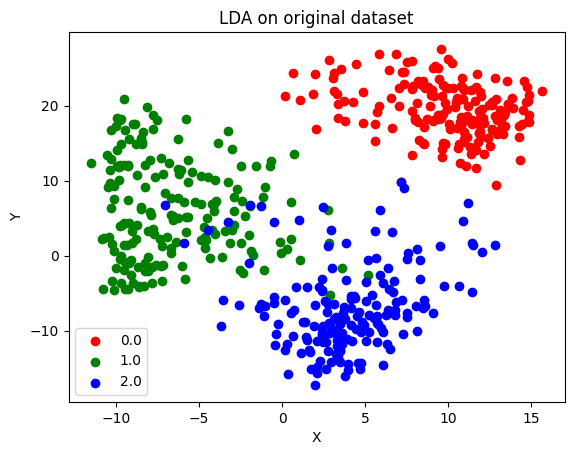

In [5]:
# Applying LDA
lda = LDA(2)
lda_X = lda.transform(X, y)

colors = ['red', 'green', 'blue']
for color, label in zip(colors, np.unique(y)):
    class_info = np.flatnonzero(y == label)
    plt.scatter(lda_X[class_info, 0], lda_X[class_info, 1], c=color, label=label)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LDA on original dataset')
plt.legend()
plt.show()

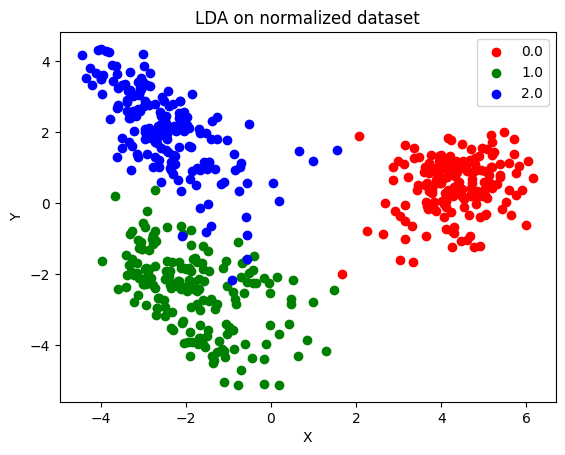

In [6]:
# Normalize the dataset - zero mean and unit variance
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
norm_X = sc.fit_transform(X)

# Applying LDA
lda = LDA(2)
lda_normX = lda.transform(norm_X, y)

colors = ['red', 'green', 'blue']
for color, label in zip(colors, np.unique(y)):
    class_info = np.flatnonzero(y == label)
    plt.scatter(lda_normX[class_info, 0], lda_normX[class_info, 1], c=color, label=label)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LDA on normalized dataset')
plt.legend()
plt.show()

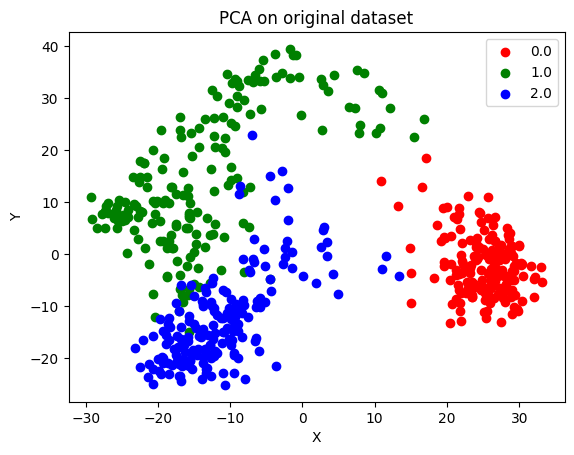

In [7]:
# PCA on original dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)

colors = ['red', 'green', 'blue']
for color, label in zip(colors, np.unique(y)):
    class_info = np.flatnonzero(y == label)
    plt.scatter(pca_X[class_info, 0], pca_X[class_info, 1], c=color, label=label)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PCA on original dataset')
plt.legend()
plt.show()

In [8]:
# Confusion Matrix
def comp_confmat(actual, predicted):
    # extract the different classes
    classes = np.unique(actual)

    # initialize the confusion matrix
    confmat = np.zeros((len(classes), len(classes)))

    # loop across the different combinations of actual / predicted classes
    for i in range(len(classes)):
        for j in range(len(classes)):
           # count the number of instances in each combination of actual / predicted classes
           confmat[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))

    return confmat

# Naive Bayes
class GaussianNB:
    def fit(self, X, t, id):
        self.priors = dict()
        self.means = dict()
        self.covs = dict()
        self.covar = np.cov(X, rowvar=False)
        
        self.classes = np.unique(t)
        IdMat = np.identity(X.shape[1])
        
        for c in self.classes:
            X_c = X[t == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.means[c] = np.mean(X_c, axis=0)
            if id == 1:
                self.covs[c] = IdMat
            elif id == 2:
                self.covs[c] = self.covar
            else:
                self.covs[c] = np.cov(X_c, rowvar=False)

                
    def predict(self, X):
        preds = list()
        for x in X:
            posts = list()
            for c in self.classes:
                prior = np.log(self.priors[c])
                inv_cov = np.linalg.inv(self.covs[c])
                inv_cov_det = np.linalg.det(inv_cov)
                diff = x-self.means[c]
                likelihood = 0.5*np.log(inv_cov_det) - 0.5*diff.T @ inv_cov @ diff
                post = prior + likelihood
                posts.append(post)
            pred = self.classes[np.argmax(posts)]
            preds.append(pred)
        return np.array(preds)

In [9]:
new_dataset = lda_X
new_dataset = np.concatenate((new_dataset, y), axis = 1)
sz = new_dataset.shape
ratio = 0.8
train_rows = int(sz[0] * ratio)

# Split the data into training and test data
i1 = np.random.choice(range(sz[0]), train_rows ,replace = False)
i2 = list(set(range(sz[0])) - set(i1))

X_train = new_dataset[i1, :]
X_test = new_dataset[i2, :]

y_train = X_train[:,-1]
y_test = X_test[:, -1]

X_train = X_train[:,0:2]
X_test = X_test[:,0:2]

In [10]:
# Build Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train, 3)
y_pred = gnb.predict(X_test)

print("Train Accuracy: ", np.sum(y_train == gnb.predict(X_train)) / y_train.shape[0])
print("Test Accuracy: ", np.sum(y_test == y_pred) / y_test.shape[0])

Train Accuracy:  0.969626168224299
Test Accuracy:  0.9444444444444444


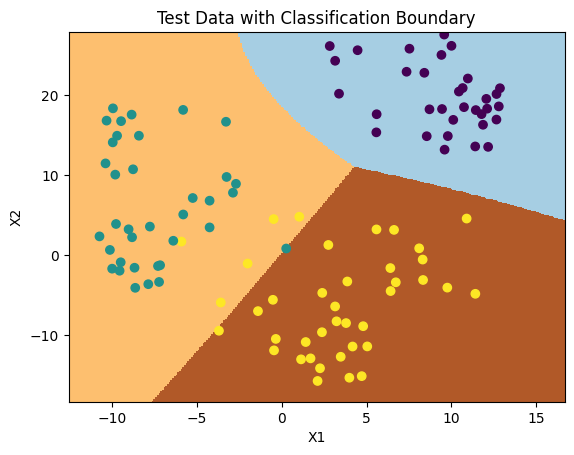

In [15]:
# Plot test data with classification boundary
min1 = np.min(X_train[:,0]) - 1
max1 = np.max(X_train[:,0]) + 1
min2 = np.min(X_train[:,1]) - 1
max2 = np.max(X_train[:,1]) + 1
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1 = xx.flatten()
r2 = yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
y_hat = gnb.predict(grid)
y_hat = y_hat.reshape(xx.shape)
plt.pcolormesh(xx, yy, y_hat, cmap='Paired')
plt.title('Test Data with Classification Boundary')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='viridis')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [17]:
# Plot confusion matrix on training and test data
confmat_train = comp_confmat(y_train, gnb.predict(X_train))
confmat_test = comp_confmat(y_test, y_pred)

print("Confusion Matrix on Training Data:")
print(confmat_train)

print("\n******************\n")

print("Confusion Matrix on Test Data:")
print(confmat_test)

Confusion Matrix on Training Data:
[[144.   0.   0.]
 [  0. 140.   6.]
 [  1.   6. 131.]]

******************

Confusion Matrix on Test Data:
[[33.  0.  0.]
 [ 0. 35.  1.]
 [ 0.  5. 34.]]
